In [1]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

### Load dataset of HuggingFace documents

In [2]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [10]:
RAW_KNOWLEDGE_BASE[0]

Document(metadata={'source': 'huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx'}, page_content=' Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://ra

### Split documents into "chunks" of text

  0%|          | 0/17995 [00:00<?, ?it/s]

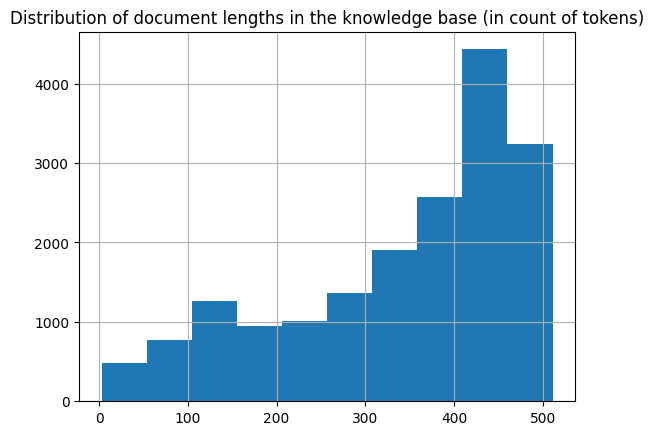

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:

    """

    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.

    """

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []

    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates

    unique_texts = {}
    docs_processed_unique = []

    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)

lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

fig = pd.Series(lengths).hist()

plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")

plt.show()

In [25]:
tokenizer.decode(tokenizer.encode(docs_processed[0].page_content))

'[CLS] create an endpoint after your first login, you will be directed to the [ endpoint creation page ] ( https : / / ui. endpoints. huggingface. co / new ). as an example, this guide will go through the steps to deploy [ distilbert - base - uncased - finetuned - sst - 2 - english ] ( https : / / huggingface. co / distilbert - base - uncased - finetuned - sst - 2 - english ) for text classification. # # 1. enter the hugging face repository id and your desired endpoint name : < img src = " https : / / raw. githubusercontent. com / huggingface / hf - endpoints - documentation / main / assets / 1 _ repository. png " alt = " select repository " / > # # 2. select your cloud provider and region. initially, only aws will be available as a cloud provider with the ` us - east - 1 ` and ` eu - west - 1 ` regions. we will add azure soon, and if you need to test endpoints with other cloud providers or regions, please let us know. < img src = " https : / / raw. githubusercontent. com / huggingface

In [29]:
docs_processed = docs_processed[:100]
len(docs_processed)

100

### Tokenization difference
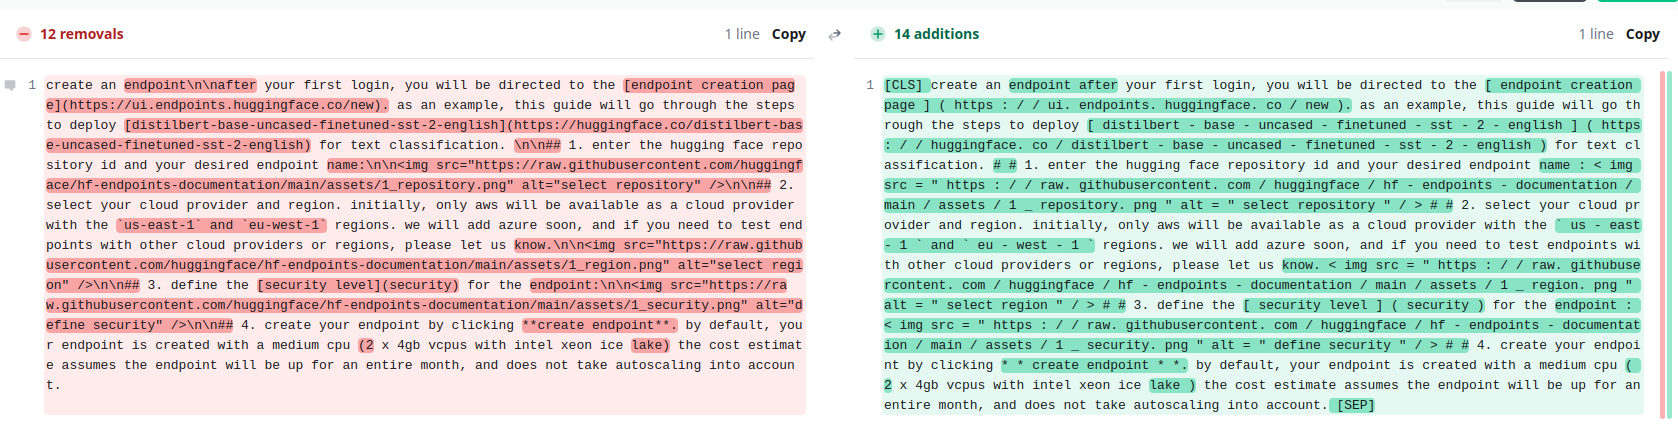

### Get embeddings for each document

In [30]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [40]:
KNOWLEDGE_VECTOR_DATABASE.similarity_search_with_score("The HuggingFace Team. All rights reserved")

[(Document(metadata={'source': 'huggingface/transformers/blob/main/README_ru.md', 'start_index': 0}, page_content='!---\nCopyright 2023 The HuggingFace Team. All rights reserved.\n\nLicensed under the Apache License, Version 2.0 (the "License");\nyou may not use this file except in compliance with the License.\nYou may obtain a copy of the License at\n\n    http://www.apache.org/licenses/LICENSE-2.0\n\nUnless required by applicable law or agreed to in writing, software\ndistributed under the License is distributed on an "AS IS" BASIS,\nWITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\nSee the License for the specific language governing permissions and\nlimitations under the License.\n-->\n\n<p align="center">\n  <picture>\n    <source media="(prefers-color-scheme: dark)" srcset="https://huggingface.co/datasets/huggingface/documentation-images/raw/main/transformers-logo-dark.svg">\n    <source media="(prefers-color-scheme: light)" srcset="https://huggingface.co/d

### Embed user query 

In [34]:
# Embed a user query in the same space
user_query = "How to create a pipeline object on huggingface?"
query_vector = embedding_model.embed_query(user_query)

In [35]:
len(query_vector)

384

### Transform embeddings into 2d vectors for visualization

In [41]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/home/juan/WhatsappAnalyzer/mundialdelectura/lib/python3.12/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [50]:
len(docs_processed)

100

In [48]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [44]:
print(f"\nStarting retrieval for {user_query=}...")

retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

print("\n==================================Top document==================================")

print(retrieved_docs[0].page_content)

print("==================================Metadata==================================")

print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object on huggingface?'...

==================================Top document==================================
```

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_1.png" alt="Astronaut Eileen Collins"/>
</div>

Pass the image and the candidate object labels to look for to the pipeline.
Here we pass the image directly; other suitable options include a local path to an image or an image url. We also pass text descriptions for all items we want to query the image for.
==================================Metadata==================================
{'source': 'huggingface/transformers/blob/main/docs/source/en/tasks/zero_shot_object_detection.md', 'start_index': 3162}
